In [70]:
import cv2
import numpy as np
from scipy.optimize import linear_sum_assignment

def compute_velocity(positions, fps):
    velocities = []
    for i in range(1, len(positions)):
        frame_velocities = {}
        for dot_id in positions[i]:
            if dot_id in positions[i - 1]:
                displacement = np.linalg.norm(np.array(positions[i][dot_id]) - np.array(positions[i - 1][dot_id]))
                velocity = displacement * fps  # Convert to units per second
                frame_velocities[dot_id] = velocity
        velocities.append(frame_velocities)
    return velocities

def track_dots(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    positions = []
    next_id = 0
    prev_positions = {}
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = frame[525:1128,400:1500]

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        current_positions = {}
        centroids = []
        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                centroids.append((cx, cy))
        
        if prev_positions:
            cost_matrix = np.zeros((len(prev_positions), len(centroids)))
            prev_ids = list(prev_positions.keys())
            
            for i, prev_id in enumerate(prev_ids):
                for j, centroid in enumerate(centroids):
                    cost_matrix[i, j] = np.linalg.norm(np.array(prev_positions[prev_id]) - np.array(centroid))
            
            row_ind, col_ind = linear_sum_assignment(cost_matrix)
            
            assigned_centroids = set()
            for i, j in zip(row_ind, col_ind):
                current_positions[prev_ids[i]] = centroids[j]
                assigned_centroids.add(j)
            
            for j, centroid in enumerate(centroids):
                if j not in assigned_centroids:
                    current_positions[next_id] = centroid
                    next_id += 1
        else:
            for centroid in centroids:
                current_positions[next_id] = centroid
                next_id += 1
        
        # Check for collisions
        collided_ids = set()
        for id1, pos1 in current_positions.items():
            for id2, pos2 in current_positions.items():
                if id1 != id2 and np.linalg.norm(np.array(pos1) - np.array(pos2)) < 10:  # Threshold for collision
                    collided_ids.add(id1)
                    collided_ids.add(id2)
        
        # Reset IDs for collided dots
        for cid in collided_ids:
            del current_positions[cid]
        
        for j, centroid in enumerate(centroids):
            if centroid not in current_positions.values():
                current_positions[next_id] = centroid
                next_id += 1
        
        positions.append(current_positions)
        prev_positions = current_positions
        
        for dot_id, (cx, cy) in current_positions.items():
            cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1)
            cv2.putText(frame, str(dot_id), (cx + 5, cy - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
        cv2.imshow('Tracking', frame)
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    velocities = compute_velocity(positions, fps)
    return velocities

# Example usage:
video_path = "241220_J10_DicerII_Chloe.avi"
velocities = track_dots(video_path)
print("Velocities:", velocities)


Velocities: [{0: np.float64(1280.9682234692632), 2: np.float64(4671.4830296771925), 3: np.float64(3783.852603628741), 4: np.float64(2738.127), 5: np.float64(2221.184808168154), 6: np.float64(1222.468291638274), 7: np.float64(729.5630783434699)}, {0: np.float64(718.6896968734143), 2: np.float64(4535.161025457531), 3: np.float64(2582.1408231206137), 4: np.float64(1825.8492860071995), 5: np.float64(3176.8713845544644), 6: np.float64(2026.9430026029345), 7: np.float64(1793.2150117980832), 8: np.float64(517.4030180913135), 10: np.float64(398.80921427294027), 11: np.float64(913.5712666070447), 12: np.float64(319.9345742257313), 13: np.float64(928.9552131141738), 14: np.float64(1599.6728711286567), 15: np.float64(4274.174120562825), 16: np.float64(1838.3125657499054), 17: np.float64(3349.395653492731), 18: np.float64(198.415)}, {0: np.float64(660.456747601991), 2: np.float64(2929.56236749621), 3: np.float64(675.7771391590575), 4: np.float64(2062.370980398289), 5: np.float64(616.0458244716865)

In [77]:
# Step 1: Get all unique animal IDs
animal_ids = set()
for frame in positions:
    animal_ids.update(frame.keys())

animal_ids = sorted(animal_ids)  # Sorting for consistent indexing

# Step 2: Initialize an empty ndarray to store the positions
num_animals = len(animal_ids)
num_frames = len(positions)

# Initialize the ndarray with NaN values to fill in missing data
position_array = np.full((num_animals, 2, num_frames), np.nan)

# Step 3: Populate the ndarray with x, y positions
for frame_idx, frame in enumerate(positions):
    for animal_idx, animal_id in enumerate(animal_ids):
        if animal_id in frame:
            x, y = frame[animal_id]
            position_array[animal_idx, 0, frame_idx] = x  # Set x position
            position_array[animal_idx, 1, frame_idx] = y  # Set y position

# Now `position_array` contains the positions with shape (num_animals, 2, num_frames)
print(position_array.shape)  # This should output (number_of_animals, 2, 100)

(286, 2, 100)


In [79]:
um_animals, _, num_frames = position_array.shape
displacement_array = np.full((num_animals, 2, num_frames - 1), np.nan)  # shape: (num_animals, 2, num_frames-1)

# Step 2: Compute the velocity for each animal
for animal_idx in range(num_animals):
    for frame_idx in range(num_frames-1):
        # Compute the change in x and y positions (Δx and Δy)
        x = position_array[animal_idx, 0, frame_idx+1]-position_array[animal_idx, 0, frame_idx]
        y = position_array[animal_idx, 1, frame_idx+1]-position_array[animal_idx, 1, frame_idx]
        
        # Store the velocity components in the velocity_array (x, y velocity)
        displacement_array[animal_idx, 0, frame_idx] = x
        displacement_array[animal_idx, 1, frame_idx] = y

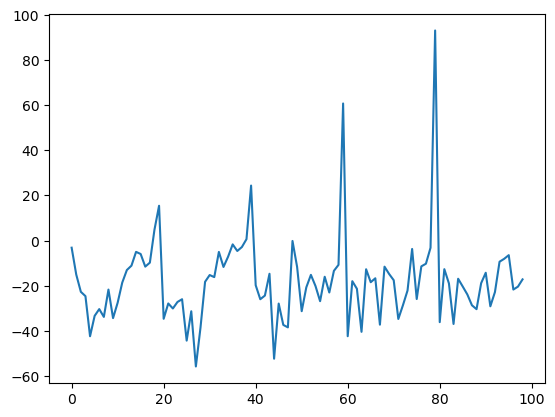

In [ ]:
plt.plot(np.nanmean(displacement_array[:,,:],axis=0))